# Application of the polynomial chaos to the cantilever beam: validation of a metamodel

## Abstract

In this example, we show to create a polynomial chaos on the cantilever beam example. The main goal of this example is to show how to create a train sample set, compute the coefficients of the polynomial and validate it with a test set. We show how to plot the validation graphics and to compute the predictability coefficient.

# Problem statement

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">



__Inputs__:  $\left\{ E, F, L, I \right\}$
* $E$ : Young modulus (Pa)
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4),
* $F$ : Loading (N)

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu=3 \times 10^4$, $\sigma=9\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

The input variables are supposed to be independent.



__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

# Model definition

We first define the input distribution. 

In [1]:
import openturns as ot

In [2]:
dist_E = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 4, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

We now define the function.

In [3]:
dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L ** 3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

We create a polynomial chaos with the following function. 

In [4]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos with least squares.

    * Uses the enumeration rule from multivariateBasis.
    * Uses LeastSquaresStrategy to compute the coefficients from
    linear least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to select the polynomials
    in the basis using least angle regression stepwise (LARS)
    * Utilise LeastSquaresStrategy pour calculer les
    coefficients par moindres carrés.
    * Uses FixedStrategy to keep all coefficients that LARS has selected,
    up to the given maximum total degree.

    Parameters
    ----------
    inputTrain : ot.Sample(n)
        The input training design of experiments with n points
    outputTrain : ot.Sample(n)
        The input training design of experiments with n points
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The maximum total polynomial degree
    myDistribution : ot.Distribution
        The distribution of the input random vector

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

Create the multivariate basis.

In [5]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [6]:
N = 50  # size of the experimental design
inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)

We can now compute the coefficients of the polynomial and get the result.

In [7]:
totalDegree = 5
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)

The `getMetaModel` method returns the metamodel function. 

In [8]:
metamodel = result.getMetaModel()  # get the metamodel
type(metamodel)

openturns.func.Function

## The predictability factor

In this section, we present the $R^2$ coefficient, which is a quality measure of the fit of the metamodel on the train set. The $R^2$ coefficient is often introducThe $Q^2$ coefficient is defined as the $R^2$ coefficient, but evaluated on the test set. 

Let $\left\{x^{(j)}_a\right\}_{j=1,...,n}$ be a i.i.d. sample of the random vector $X$, used to train the metamodel. 

Let $g$ be the model and $\tilde{g}$ the metamodel. 

Let 

$$
y^{(j)}_a = g\left(x^{(j)}_a\right), \qquad \tilde{y}^{(j)}_a = \tilde{g}\left(x^{(j)}_a\right)
$$

for $j=1,...,n$ the outputs of the model and metamodel on the train set. 

Then the $R^2$ coefficient is :

$$
R^2(g(x_a),\tilde{g}(x_a)) = 1 - \frac{ \sum_{j=1}^N \left( y^{(j)}_a - \tilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^N \left( y^{(j)}_a - \bar{y}_a \right)^2 }
$$

where $\bar{y}_a = \frac{1} {N} \sum_{i=1}^N y^{(j)}_a$. 
The metamodel is involved only in the numerator of the previous fraction. 

Assume that a second design of experiments, the test set, is generated: $\left\{x^{(j)}_v\right\}_{j=1,...,n}$. 

Let $g(x_v)$ et $\tilde{g}(x_v)$ the outputs of the model and metamodel on the test set. 

Then the $Q^2$ coefficient is equal to the $R^2$ evaluated on the test set: 

$$
Q^2 = R^2(g(x_v),\tilde{g}(x_v)).
$$

The 

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [9]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [10]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictability coefficient

In [11]:
Q2 = val.computePredictivityFactor()
Q2

class=Point name=Unnamed dimension=1 values=[0.972674]

A metamodel which has a $Q^2$ coefficient greater than 0.95 is considered as good. Greater than 0.99 is excellent. 

Plot the observed versus the predicted outputs.

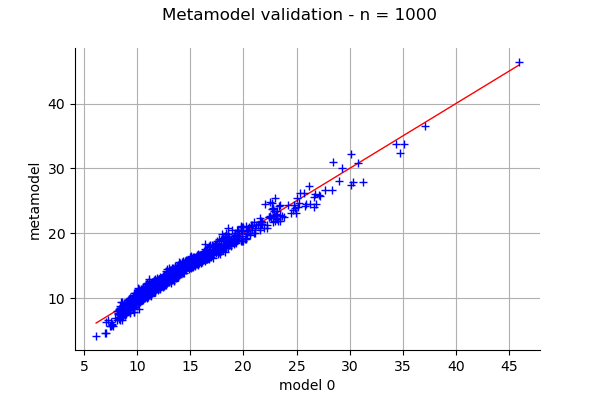

In [12]:
val.drawValidation()

When the metamodel predictions are close to the observations, the points are close to the diagonal. 

## Conclusion

Before using a metamodel, we must test it against a design of experiments which has not been used to compute the coefficients. The predictability factor and the validation plot can help to measure the quality. 